# Predicting changes in conflict intensity

### Importing packages and data

First, import all modules necessary

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import operator as op
import math

from shutil import copyfile

import numpy as np
import os
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

data_path = "../../data/Test_training/"

Then load the preprocessed datafiles and column lists:

In [2]:
with open('../../data/Test_training/local_regional_global.pkl', 'rb') as f:
    data_dict = pickle.load(f)

In [4]:
# load local, regional and global dataset
local_data = data_dict["Local"]
regional_data = data_dict["Regional"]
global_data = data_dict["International"]

In [5]:
# set variables for column lists
predictor_columns = data_dict["pred_columns"]
history_columns = data_dict["hist_columns"] 
themes_columns = data_dict["theme_columns"]
change_columns = data_dict["change_columns"]

In [6]:
history_columns = ["fatalities", "fatalities t-1", "fatalities t-2", "fatalities t-3",
                       "cumulated_best_3", "cumulated_best_6", "cumulated_best_12",
                       "m_since_best_50", "m_since_best_500", "m_since_best_2000"]

### Functions for predicting

We make a function that predicts over the entire sample, for one month at a time

In [7]:
def predict(X, Y, base_months, months_ahead, model):

    total_months = len(X)

    Y_true = Y[base_months:]
    Y_predicted = []

    # predict one month ahead at a time
    for month in range(base_months+1-months_ahead, total_months+1-months_ahead):

        X_train = X[:month]
        X_test = X[month+months_ahead-1:month+months_ahead]
        y_train = Y[:month]
        y_test = Y[month+months_ahead-1:month+months_ahead]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        prediction = model.predict(X_test)

        # store prediction
        Y_predicted.append(float(prediction[0]))
    
    return Y_true, Y_predicted

We need a custom mse function, since our prediction function will result in out-of-sample forecasts

In [8]:
def custom_mse(data, true_column, predict_column):
    Ytrue = data[true_column]
    Ypredict = data[predict_column]

    valid_indices = ~np.isnan(Ytrue) & ~np.isnan(Ypredict)
    Ytrue_valid = Ytrue[valid_indices]
    Ypredict_valid = Ypredict[valid_indices]

    mse = mean_squared_error(Ytrue_valid, Ypredict_valid)

    return mse

Then, a function to find the 20 most correlated themes for a specific predictor column:

In [9]:
def get_features(data, columns, corr_columns):
    corrs = data[columns].corr()

    # Calculate and combine correlations into one series
    combined_corrs = pd.concat([
        corrs.loc[~corrs.index.isin(predictor_columns), corr_columns[0]],
        corrs.loc[~corrs.index.isin(predictor_columns), corr_columns[1]]
    ])

    # Sort the combined correlations by their absolute values while retaining the sign
    sorted_combined_corrs = combined_corrs.sort_values(key=abs, ascending=False)

    # Select the top 20 unique items
    top_20_unique_corrs = sorted_combined_corrs[~sorted_combined_corrs.index.duplicated()].head(20)

    return top_20_unique_corrs

And a function to perform grid search over a parameter set

In [10]:
def advanced_grid_search(data, features, true_column, param_grid, base_months, months_ahead, mse_log=True):

    # iterate over parameter combinations:
    combinations_dict = {}
    i = 0

    lowest_mse = float('inf')
    lowest_mse_log = float('inf')
    best_params_log = None
    best_params_name_log = None
    best_params_mse = None
    best_params_name_mse = None

    for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                for min_samples_split in param_grid['min_samples_split']:
                    for min_samples_leaf in param_grid['min_samples_leaf']:
                        # add to combinations_dict
                        combinations_dict[f"params_{i}"] = {
                            "parameters" : {'n_estimators': n_estimators,
                                            'max_depth': max_depth,
                                            'min_samples_split': min_samples_split,
                                            'min_samples_leaf': min_samples_leaf,},
                            "MSE" : False,
                            "MSE_log" : False,
                            }
                        i+=1

    for n, item in enumerate(combinations_dict.keys()):
        print(f"Predicting with parameter set {n}/{len(combinations_dict)}", end="\r")
        params = combinations_dict[item]["parameters"]

        model = RandomForestRegressor(**params, random_state=42)

        Y_true, Y_predicted = predict(data[features], data[true_column], base_months, months_ahead, model)

        predicted_column = f'predicted {true_column}'
        data[predicted_column] = list(pd.Series([float('nan')] * base_months)) + Y_predicted

        # compute log change
        data[f"predicted log change t+{months_ahead}"] = np.log(data[predicted_column] + 1) - np.log(data["fatalities"] + 1)

        true_log_column = f"log change t+{months_ahead}"
        predicted_log_column = f"predicted log change t+{months_ahead}"

        mse = custom_mse(data, true_column, predicted_column)
        mse_log = custom_mse(data, true_log_column, predicted_log_column)
        combinations_dict[item]["MSE"] = mse
        combinations_dict[item]["MSE_log"] = mse_log


        if mse_log < lowest_mse_log:
            lowest_mse_log = mse
            best_params_log = params
            best_params_name_log = item
        if mse < lowest_mse:
            lowest_mse = mse
            best_params_mse = params
            best_params_name_mse = item

    if mse_log:
        return combinations_dict, lowest_mse_log, best_params_log
    else:
        return combinations_dict, lowest_mse, best_params_mse

From the dictionary that is returned, we can then find the lowest mse and corresponding parameters

In [11]:
def find_lowest_mse(dict):
    lowest_mse_entry = None
    lowest_mse_log_entry = None

    # Initialize variables to store the lowest MSE and MSE_log values
    lowest_mse = float('inf')
    lowest_mse_log = float('inf')

    # Iterate through the dictionary
    for key, value in dict.items():
        # Check if current MSE is lower than the lowest MSE found so far
        if value['MSE'] < lowest_mse:
            lowest_mse = value['MSE']
            lowest_mse_entry = key
        
        # Check if current MSE_log is lower than the lowest MSE_log found so far
        if value['MSE_log'] < lowest_mse_log:
            lowest_mse_log = value['MSE_log']
            lowest_mse_log_entry = key

    # Print the entry with the lowest MSE and the lowest MSE_log
    print("Entry with lowest MSE:")
    print(dict[lowest_mse_entry])

    print("\nEntry with lowest MSE_log:")
    print(dict[lowest_mse_log_entry])

And finally, plot the results against the original data:

In [12]:
def plot_results(data, x, y1, y2, ylabel, legend_label, title):
    y1 = data[y1]
    y2 = data[y2]

    plt.figure(figsize=(10, 6))
    plt.plot(x, y1, label='Data')
    plt.plot(x, y2, label=legend_label, linestyle="--", color="red")
    plt.xlabel('Month')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(x[::12])  # Ensure all months are shown on x-axis
    plt.legend()
    plt.grid(True)
    plt.show()

### Parameter tuning for all 7 models:

First, derive all the 7 feature sets:

In [13]:
all_columns = predictor_columns + themes_columns + change_columns

# make features for themes
top_20_unique_corrs_loc = get_features(local_data, all_columns, ["fatalities t+1", "log change t+1"])
top_20_unique_corrs_reg = get_features(regional_data, all_columns, ["fatalities t+1", "log change t+1"])
top_20_unique_corrs_glo = get_features(global_data, all_columns, ["fatalities t+1", "log change t+1"])

features_history = history_columns
features_local = list(top_20_unique_corrs_loc.index)
features_regional = list(top_20_unique_corrs_reg.index) 
features_global = list(top_20_unique_corrs_glo.index) 
features_local_history = list(top_20_unique_corrs_loc.index) + history_columns
features_regional_history = list(top_20_unique_corrs_reg.index) + history_columns
features_global_history = list(top_20_unique_corrs_glo.index) + history_columns

In [14]:
features_global

['INSURGENCY',
 'WB_2468_CONVENTIONAL_WAR',
 'WB_2451_REBELS_GUERRILLAS_AND_INSURGENTS',
 'WB_1104_MACROECONOMIC_VULNERABILITY_AND_DEBT',
 'WB_2445_NON_STATE_SECURITY_ACTORS',
 'ECON_INFLATION',
 'WB_442_INFLATION',
 'FOOD_SECURITY',
 'SOC_POINTSOFINTEREST_AIRPORT',
 'WB_1804_AIRPORTS',
 'SELF_IDENTIFIED_HUMANITARIAN_CRISIS',
 'WB_990_DRAINAGE',
 'TERROR',
 'UNGP_AFFORDABLE_NUTRITIOUS_FOOD',
 'WB_2462_POLITICAL_VIOLENCE_AND_WAR',
 'SECURITY_SERVICES',
 'WB_1803_TRANSPORT_INFRASTRUCTURE',
 'WB_990_DRAINAGE change',
 'TAX_WORLDLANGUAGES_UKRAINIAN',
 'TAX_ETHNICITY_UKRAINIAN']

Then, we manually perform grid search for each model and feature set:

In [392]:
# parameters to test
param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],     
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]    
        }

# --------------------------------------
# Adjust for feature-dataset combination
# --------------------------------------
features = features_global
data = global_data.copy()

# set variables for grid search
base_months = 12
months_ahead = 1
true_column = f"fatalities t+{months_ahead}"

# perform grid search and lowest mse
dict, lowest_score, best_params = advanced_grid_search(data, features, true_column, param_grid, base_months, months_ahead)
find_lowest_mse(dict)

Entry with lowest MSE:ter set 80/81
{'parameters': {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}, 'MSE': 2262982.6180063454, 'MSE_log': 1.4670126002111776}

Entry with lowest MSE_log:
{'parameters': {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}, 'MSE': 2421707.3910000003, 'MSE_log': 1.4130713864727082}


#### Stored results

In [15]:
best_params_history = {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2}
# 'MSE': 1653663.206455201, 'MSE_log': 0.6090994662472196}
best_params_history_local = {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
# 'MSE': 1522410.737989189, 'MSE_log': 0.5482476828935202}
best_params_history_regional = {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
# 'MSE': 1598320.3111135133, 'MSE_log': 0.9339650693699929}
best_params_history_global = {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
# 'MSE': 1756452.9297572337, 'MSE_log': 1.0187120493772577}
best_params_local = {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
# 'MSE': 1518488.7847815177, 'MSE_log': 0.5183944549346611}
best_params_regional = {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}
# 'MSE': 1875315.5502898048, 'MSE_log': 1.0314897283001083}}
best_params_global = {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1}
# 'MSE': 2421707.3910000003, 'MSE_log': 1.4130713864727082}

### Predicting for T+1 till T+6

Make a dictionary for all the models and corresponding parameter sets, features, and datasets

In [12]:
models_dict = {
    "History" : {
        "data" : local_data,
        "best_params" : best_params_history,
        "features" : history_columns
    },
    "History_local" : {
        "data" : local_data,
        "best_params" : best_params_history_local,
        "features" : features_local_history
    },
    "History_regional" : {
        "data" : regional_data,
        "best_params" : best_params_history_regional,
        "features" : features_regional_history
    },
    "History_global" : {
        "data" : global_data,
        "best_params" : best_params_history_global,
        "features" : features_global_history
    },
    "Local" : {
        "data" : local_data,
        "best_params" : best_params_local,
        "features" : features_local
    },
    "Regional" : {
        "data" : regional_data,
        "best_params" : best_params_regional,
        "features" : features_regional
    },
    "Global" : {
        "data" : global_data,
        "best_params" : best_params_global,
        "features" : features_global
    },
}

And then we predict for all the different models:

In [23]:
# set basic variables
base_months = 12
mse_table = pd.DataFrame(columns=["Model", "t+1", "t+2", "t+3", "t+4", "t+5", "t+6"])

saved_data = local_data[["Month"] + predictor_columns].copy()

for key, value in models_dict.items():
    # grab title
    model_name = key
    # grab variables
    best_params = value["best_params"]
    data = value["data"].copy()
    features = value["features"]

    model = RandomForestRegressor(**best_params, random_state=42)

    model_scores = [model_name]

    for i in range(1,7):
        print(f"Predicting {model_name} t+{i}                    ", end="\r")
        # change month
        months_ahead = i

        # set column names
        true_column = f"fatalities t+{months_ahead}"
        true_log_column = f"log change t+{months_ahead}"
        predicted_column = f'predicted {true_column}'
        predicted_log_column = f"predicted log change t+{months_ahead}"

        # predict
        Y_true, Y_predicted = predict(data[features], data[true_column], base_months, months_ahead, model)

        # save results in data
        data[predicted_column] = list(pd.Series([float('nan')] * base_months)) + Y_predicted
        # set log change
        data[true_log_column] = np.log(data[true_column] + 1) - np.log(data["fatalities"] + 1)
        data[predicted_log_column] = np.log(data[predicted_column] + 1) - np.log(data["fatalities"] + 1)

        # calculate and save MSE
        mse = custom_mse(data, true_column, predicted_column)
        mse_log = custom_mse(data, true_log_column, predicted_log_column)

        model_scores.append({"MSE" : mse, "MSE_LOG" : mse_log})

        # save predicted values to saved data
        alt_name = f"{key} predicted change t+{months_ahead}"
        alt_name_log = f"{key} predicted log change t+{months_ahead}"

        saved_data[alt_name] = data[predicted_column]
        saved_data[alt_name_log] = data[predicted_log_column]

    # append new row of mse scores to mse table
    mse_table.loc[len(mse_table)] = model_scores

# mse_table.head()

Which gives the following results:

In [32]:
mse_logs = mse_table.copy()

# Apply transformation to columns not in the exclude list
for column in mse_logs.columns:
    if column not in ["Model"]:
        mse_logs[column] = mse_logs[column].apply(lambda x: x["MSE_LOG"])

mse_logs.set_index("Model", inplace=True)
mse_logs.T

Model,History,History_local,History_regional,History_global,Local,Regional,Global
t+1,0.539525,0.492155,1.030427,1.031839,0.467815,1.198820,1.397765
t+2,1.133747,1.029422,2.141931,1.626502,0.823575,1.736598,1.607731
t+3,1.683153,1.609891,2.849415,1.910611,1.172673,2.189549,1.731144
t+4,2.302750,2.358165,3.147067,2.871224,1.464059,2.009214,2.216157
t+5,2.839400,3.417670,2.784061,3.337918,1.920404,1.689868,2.764546
t+6,2.914362,4.030668,2.276915,4.149829,2.198780,1.746545,3.326496


### Vizualizing

We can vizualize the MSE for different forecasting windows for each model:

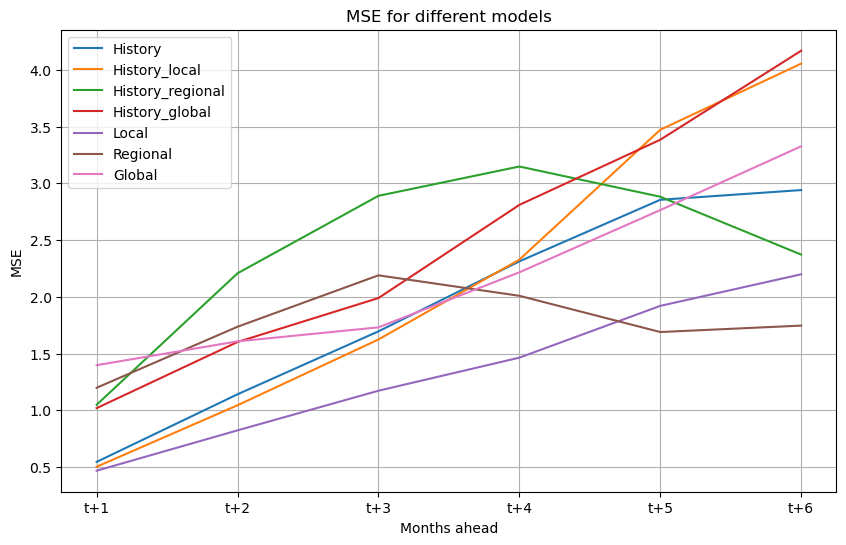

In [456]:
# plot a line for each row in the "mses" dataframe
plt.figure(figsize=(10, 6))
for i in range(len(mse_logs)):
    plt.plot(mse_logs.columns, mse_logs.iloc[i,], label=mse_logs.index[i])
    plt.xlabel('Months ahead')
    plt.ylabel('MSE')
    plt.title('MSE for different models')
    plt.legend()
    plt.grid(True)
plt.show()

And, from the `saved_data` dataframe, make vizualizations for individual models

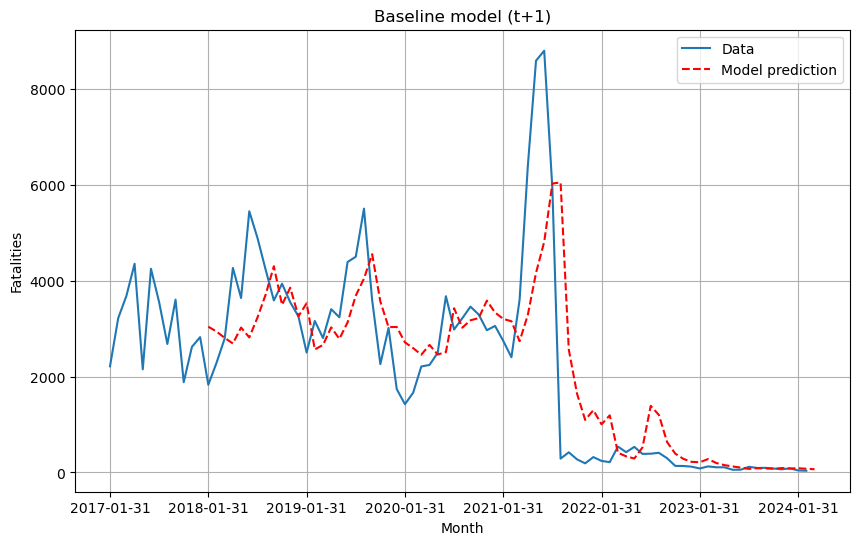

In [17]:
 # set column names
model = "History"
months_ahead = 1
true_column = f"fatalities t+{months_ahead}"
true_log_column = f"log change t+{months_ahead}"
predicted_column = f'{model} predicted change t+{months_ahead}'
predicted_log_column = f"{model} predicted log change t+{months_ahead}"

# plot mse over time:
plot_results(saved_data, saved_data["Month"], true_column, predicted_column, "Fatalities", "Model prediction", "Baseline model (t+1)")

We also save both the mse table and the saved data for future use:

In [35]:
mse_logs.T.to_csv("../../data/results/mse_results.csv")

In [460]:
saved_data.to_pickle("../../data/results/all_results_v1.pkl")

In [16]:
# read saved data
saved_data = pd.read_pickle("../../data/results/all_results_v1.pkl")

In [3]:
mse_logs = pd.read_csv("../../data/results/mse_results.csv")
mse_logs.head()

,Unnamed: 0,History,History_local,History_regional,History_global,Local,Regional,Global
0,t+1,0.539525,0.492155,1.030427,1.031839,0.467815,1.198820,1.397765
1,t+2,1.133747,1.029422,2.141931,1.626502,0.823575,1.736598,1.607731
2,t+3,1.683153,1.609891,2.849415,1.910611,1.172673,2.189549,1.731144
3,t+4,2.302750,2.358165,3.147067,2.871224,1.464059,2.009214,2.216157
4,t+5,2.839400,3.417670,2.784061,3.337918,1.920404,1.689868,2.764546


In [10]:
# compute the average of each column of mse_logs
average_mse = mse_logs.drop(columns="Unnamed: 0").mean(axis=0)
average_mse

History             1.902156
History_local       2.156328
History_regional    2.371636
History_global      2.487987
Local               1.341218
Regional            1.761766
Global              2.173973
dtype: float64

In [62]:
model_to_test = ["Local", "Regional", "Global"]

test_data = saved_data.copy()
for model in model_to_test:
    months_ahead = 1
    true_column = f"fatalities t+{months_ahead}"
    true_log_column = f"log change t+{months_ahead}"
    predicted_column = f'{model} predicted change t+{months_ahead}'
    predicted_log_column = f"{model} predicted log change t+{months_ahead}"
    error_column = f"error_squared {model}"

    test_data[error_column] = (test_data[true_log_column] - test_data[predicted_log_column])**2

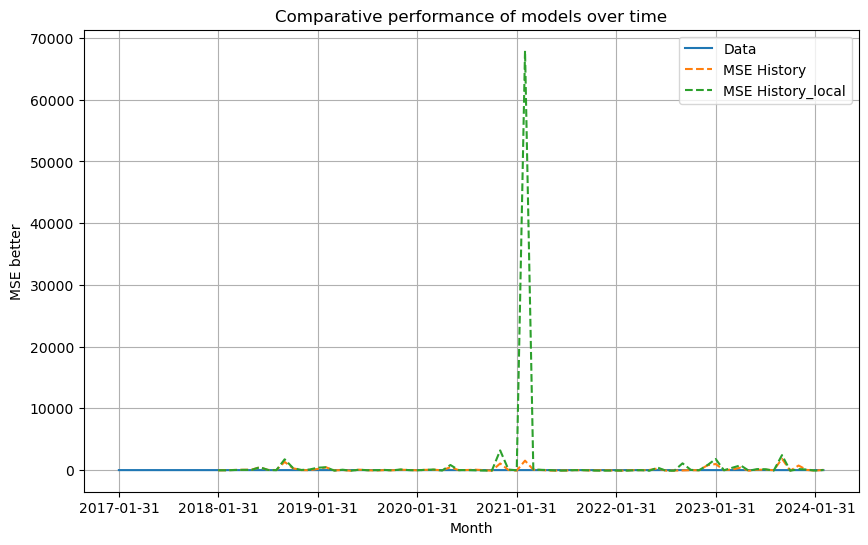

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Data')

model = "History"
model_2 = "History_local"
model_3 = "Local"

# calculate mse of m

plt.plot(x, y2, label=f"MSE {model}", linestyle="--")
plt.plot(x, y3, label=f"MSE {model_2}", linestyle="--")
plt.xlabel('Month')
plt.ylabel("MSE better")
plt.title("Comparative performance of models over time")
plt.xticks(x[::12])  # Ensure all months are shown on x-axis
plt.legend()
plt.grid(True)
plt.show()

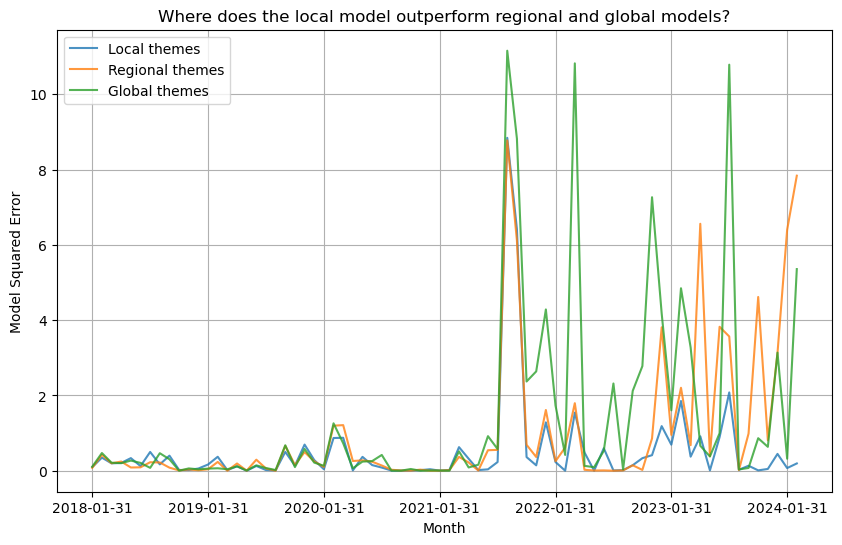

In [69]:

x = test_data["Month"]
y1 = test_data[true_log_column]

plt.figure(figsize=(10, 6))
# plt.plot(x, y1, label='Data')
for model in model_to_test:
    y2 = test_data[f"error_squared {model}"]
    if model == "Regional":
        plt.plot(x[12:], y2[12:], label=f"Regional themes", alpha=0.8)
    if model == "Global":
        plt.plot(x[12:], y2[12:], label=f"Global themes", alpha=0.8)
    if model == "Local":
        plt.plot(x[12:], y2[12:], label=f"Local themes", alpha=0.8)
plt.xlabel('Month')
plt.ylabel("Model Squared Error")
plt.title("Where does the local model outperform regional and global models?")
plt.xticks(x[12::12])  # Ensure all months are shown on x-axis
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# x = test_data["Month"]
# y1 = test_data[true_log_column]
# y2 = test_data[error_column]

# fig, ax1 = plt.subplots(figsize=(10, 6))

# color = 'tab:blue'
# ax1.set_xlabel('Month')
# ax1.set_ylabel('Data', color=color)
# ax1.plot(x, y1, label='Data', color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  
# color = 'tab:red'
# ax2.set_ylabel('Model Error', color=color)
# ax2.plot(x, y2, label='Log change', linestyle='--', color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.suptitle('MSE over time')
# plt.xticks(x[::12])  # Ensure all months are shown on x-axis
# fig.legend()
# plt.grid(True)
# plt.show()
